In [87]:
import numpy as np
import cupy as cp
from numba import cuda, vectorize, float32
import time

# Размер данных
N = 10_000_000

# Подготовка данных
x_cpu = np.random.rand(N).astype(np.float32)
y_cpu = np.random.rand(N).astype(np.float32)

x_cupy = cp.array(x_cpu)
y_cupy = cp.array(y_cpu)

@cp.fuse()
def cupy_compute(x, y):
    return x**2 + y**2 + 2*x*y

@vectorize([float32(float32, float32)], target='cuda')
def numba_compute(x, y):
    return x**2 + y**2 + 2*x*y

_ = cupy_compute(x_cupy, y_cupy)
cp.cuda.Device().synchronize()
_ = numba_compute(x_cupy, y_cupy)
cuda.synchronize()


start = time.time()
result_cupy = cupy_compute(x_cupy, y_cupy)
cp.cuda.Device().synchronize()
cupy_time = time.time() - start

# Бенчмарк Numba
start = time.time()
result_numba = numba_compute(x_cupy, y_cupy)
cuda.synchronize()
numba_time = time.time() - start

print(f"CuPy time: {cupy_time*1000:.2f} ms")
print(f"Numba time: {numba_time*1000:.2f} ms")
print(f"Speedup: {numba_time/cupy_time:.2f}x")

CuPy time: 1.12 ms
Numba time: 2.60 ms
Speedup: 2.33x


In [88]:
# Размер матриц
M, K, N = 2048, 2048, 2048

# Подготовка данных
A_cpu = np.random.rand(M, K).astype(np.float32)
B_cpu = np.random.rand(K, N).astype(np.float32)

A_cupy = cp.array(A_cpu)
B_cupy = cp.array(B_cpu)
A_numba = cuda.to_device(A_cpu)
B_numba = cuda.to_device(B_cpu)

# CuPy матричное умножение
start = time.time()
C_cupy = cp.dot(A_cupy, B_cupy)
cp.cuda.Device().synchronize()
cupy_time = time.time() - start

# Numba CUDA kernel для матричного умножения
@cuda.jit
def matmul_kernel(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.0
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

C_numba = cuda.device_array((M, N), dtype=np.float32)
threadsperblock = (16, 16)
blockspergrid_x = (M + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (N + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Warmup
matmul_kernel[blockspergrid, threadsperblock](A_numba, B_numba, C_numba)
cuda.synchronize()

# Бенчмарк Numba
start = time.time()
matmul_kernel[blockspergrid, threadsperblock](A_numba, B_numba, C_numba)
cuda.synchronize()
numba_time = time.time() - start

print(f"\nMatrix Multiplication ({M}x{K} @ {K}x{N}):")
print(f"CuPy time: {cupy_time*1000:.2f} ms")
print(f"Numba time: {numba_time*1000:.2f} ms")
print(f"CuPy speedup: {numba_time/cupy_time:.2f}x")



Matrix Multiplication (2048x2048 @ 2048x2048):
CuPy time: 6.32 ms
Numba time: 185.84 ms
CuPy speedup: 29.40x


In [89]:
N = 50_000_000

data_cpu = np.random.rand(N).astype(np.float32)
data_cupy = cp.array(data_cpu)
data_numba = cuda.to_device(data_cpu)

start = time.time()
result_cupy = cp.sum(data_cupy)
cp.cuda.Device().synchronize()
cupy_time = time.time() - start

@cuda.reduce
def sum_reduce(a, b):
    return a + b

# тестовый прогон для компилляции функций
_ = sum_reduce(data_numba)
cuda.synchronize()

start = time.time()
result_numba = sum_reduce(data_numba)
cuda.synchronize()
numba_time = time.time() - start

print(f"\nReduction (sum of {N} elements):")
print(f"CuPy time: {cupy_time*1000:.2f} ms")
print(f"Numba time: {numba_time*1000:.2f} ms")
print(f"Speedup: {numba_time/cupy_time:.2f}x")

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))



Reduction (sum of 50000000 elements):
CuPy time: 1.22 ms
Numba time: 1.54 ms
Speedup: 1.27x


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [90]:
N = 10_000_000
threshold = 0.5

data_cpu = np.random.rand(N).astype(np.float32)
data_cupy = cp.array(data_cpu)


@cp.fuse()
def cupy_threshold(x):
    return cp.where(x > 0.5, x**2, cp.sqrt(cp.abs(x)))


@cuda.jit
def numba_threshold_kernel(x, out):
    idx = cuda.grid(1)
    if idx < x.shape[0]:
        if x[idx] > 0.5:
            out[idx] = x[idx]**2
        else:
            out[idx] = abs(x[idx])**0.5


_ = cupy_threshold(data_cupy)
cp.cuda.Device().synchronize()


start = time.time()
result_cupy = cupy_threshold(data_cupy)
cp.cuda.Device().synchronize()
cupy_time = time.time() - start

data_numba = cuda.to_device(data_cpu)
out_numba = cuda.device_array(N, dtype=np.float32)
threads_per_block = 256
blocks_per_grid = (N + threads_per_block - 1) // threads_per_block

numba_threshold_kernel[blocks_per_grid, threads_per_block](data_numba, out_numba)
cuda.synchronize()

start = time.time()
numba_threshold_kernel[blocks_per_grid, threads_per_block](data_numba, out_numba)
cuda.synchronize()
numba_time = time.time() - start

print(f"\nConditional operations ({N} elements):")
print(f"CuPy time: {cupy_time*1000:.2f} ms")
print(f"Numba time: {numba_time*1000:.2f} ms")
print(f"Speedup: {numba_time/cupy_time:.2f}x")

ERROR:numba.cuda.cudadrv.driver:Call to cuMemAlloc results in CUDA_ERROR_OUT_OF_MEMORY



Conditional operations (10000000 elements):
CuPy time: 0.47 ms
Numba time: 7.92 ms
Speedup: 16.97x


In [91]:
import time
import numpy as np
import cupy as cp
from numba import cuda, float32

def gpu_time(fn, iters=30, warmup=5):
    for _ in range(warmup):
        fn()
    cp.cuda.Stream.null.synchronize()

    start = cp.cuda.Event()
    end = cp.cuda.Event()

    times = []
    for _ in range(iters):
        start.record()
        fn()
        end.record()
        end.synchronize()
        times.append(cp.cuda.get_elapsed_time(start, end))
    return np.median(times)


In [92]:
def bench_line(n=10_000_000, dtype=cp.float32):
    x = cp.random.random(n, dtype=dtype)
    y = cp.random.random(n, dtype=dtype)
    a = 1.25
    b = -0.75


    def cupy_fn():
        return a * x + b * cp.sin(y)


    @cuda.jit
    def axpby_kernel(xd, yd, a, b, out):
        i = cuda.grid(1)
        if i < out.size:
            out[i] = a * xd[i] + b * yd[i]

    xd = cuda.as_cuda_array(x)
    yd = cuda.as_cuda_array(y)
    out = cp.empty_like(x)
    outd = cuda.as_cuda_array(out)

    threads = 256
    blocks = (n + threads - 1) // threads

    def numba_fn():
        axpby_kernel[blocks, threads](xd, yd, a, b, outd)

    return (
        gpu_time(cupy_fn),
        gpu_time(numba_fn),
    )


In [93]:
def bench_arithm(n=10_000_000, dtype=cp.float32):
    x = cp.random.random(n, dtype=dtype)

    def cupy_fn():
        return cp.sum(x)

    @cuda.reduce
    def sum_reduce(a, b):
        return a + b

    xd = cuda.as_cuda_array(x)

    def numba_fn():
        return sum_reduce(xd)

    return (
        gpu_time(cupy_fn),
        gpu_time(numba_fn),
    )


In [94]:
def bench_matmul(n=2048, dtype=cp.float32):
    A = cp.random.random((n, n), dtype=dtype)
    B = cp.random.random((n, n), dtype=dtype)

    def cupy_fn():
        return A @ B

    @cuda.jit
    def mul(A, B, C):
        TPB = 32
        # Define an array in the shared memory
        # The size and type of the arrays must be known at compile time
        sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
        sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

        x, y = cuda.grid(2)

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y
        bpg = cuda.gridDim.x    # blocks per grid

        if x >= C.shape[0] and y >= C.shape[1]:
            # Quit if (x, y) is outside of valid C boundary
            return

        # Each thread computes one element in the result matrix.
        # The dot product is chunked into dot products of TPB-long vectors.
        tmp = 0.
        for i in range(bpg):
            # Preload data into shared memory
            sA[tx, ty] = A[x, ty + i * TPB]
            sB[tx, ty] = B[tx + i * TPB, y]

            # Wait until all threads finish preloading
            cuda.syncthreads()

            # Computes partial product on the shared memory
            for j in range(TPB):
                tmp += sA[tx, j] * sB[j, ty]

            # Wait until all threads finish computing
            cuda.syncthreads()

        C[x, y] = tmp

    Ad = cuda.as_cuda_array(A)
    Bd = cuda.as_cuda_array(B)
    C = cp.empty((n, n), dtype=dtype)
    Cd = cuda.as_cuda_array(C)

    threads = (32, 32)
    blocks = ((n + threads[0] - 1)//threads[0], (n + threads[1] - 1)//threads[1])

    def numba_fn():
        mul[blocks, threads](Ad, Bd, Cd)

    return (
        gpu_time(cupy_fn, iters=10, warmup=2),
        gpu_time(numba_fn, iters=10, warmup=2),
    )

In [95]:

def bench_stencil(n=10_000_000, dtype=cp.float32):
    x = cp.random.random(n, dtype=dtype)
    out = cp.empty_like(x)

    def cupy_fn():
        out[1:-1] = 0.25*x[:-2] + 0.5*x[1:-1] + 0.25*x[2:]

    @cuda.jit
    def stencil(x, out):
        i = cuda.grid(1)
        if 1 <= i < out.size - 1:
            out[i] = 0.25*x[i-1] + 0.5*x[i] + 0.25*x[i+1]

    xd = cuda.as_cuda_array(x)
    outd = cuda.as_cuda_array(out)
    threads = 256
    blocks = (n + threads - 1) // threads

    def numba_fn():
        stencil[blocks, threads](xd, outd)

    return (
        gpu_time(cupy_fn),
        gpu_time(numba_fn),
    )

In [96]:
Test_arr = np.logspace(3, 8.5, 10, base=10, dtype=int)

line_time = np.array([bench_line(n) for n in Test_arr])
print(1)
arithm_time = np.array([bench_arithm(n) for n in Test_arr])
print(2)
stencil_time = np.array([bench_stencil(n) for n in Test_arr])
print(3)

# Mat_arr = np.logspace(8, 11, 6, base=2, dtype=int)
# matmul_time = np.array([bench_matmul(n) for n in Mat_arr])

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 66 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 31 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size

2


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 66 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


3


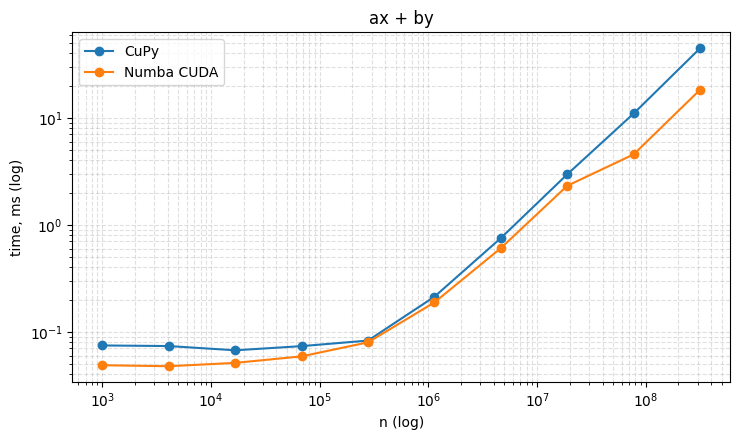

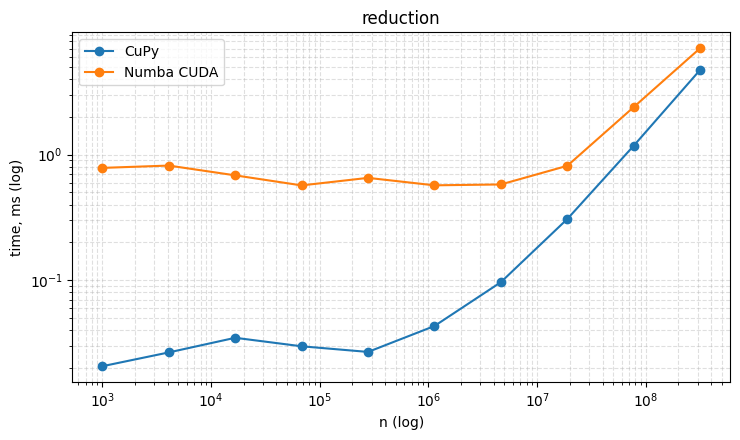

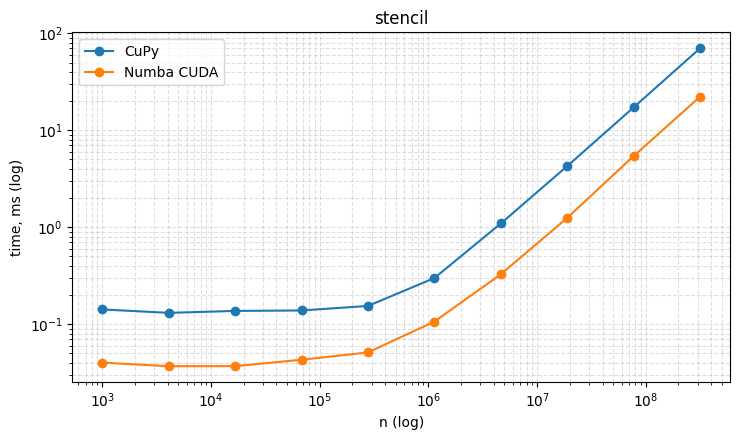

In [97]:
import matplotlib.pyplot as plt

def plot_time(data, xaxis, name):
  fig, ax = plt.subplots(figsize=(7.5, 4.5))

  CP_time = data[:, 0]
  Numba_time = data[:, 1]

  ax.plot(xaxis, CP_time, marker="o", label="CuPy")
  ax.plot(xaxis, Numba_time, marker="o", label="Numba CUDA")

  ax.set_xscale("log")
  ax.set_yscale("log")
  ax.set_xlabel("n (log)")
  ax.set_ylabel("time, ms (log)")
  ax.set_title(name)
  ax.grid(True, which="both", linestyle="--", alpha=0.4)
  ax.legend()
  fig.tight_layout()
  fig.show()

plot_time(line_time, Test_arr, "ax + by")
plot_time(arithm_time, Test_arr, "reduction")
plot_time(stencil_time, Test_arr, "stencil")
# plot_time(matmul_time, Mat_arr, "matrix mul")